In [ ]:
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [ ]:
import nltk
from nltk.corpus import stopwords
import re

from wordcloud import WordCloud
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

import numpy as np
import pandas as pd


import json

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


# Data Preparation 

In [ ]:
def utils_preprocess_text(text):
    
    #text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'[^[a-zA-Z]\s]', '', str(text).lower().strip())
  
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    if stop is not None:
      lst_text = [word for word in lst_text if word not in 
                  stop]
                

    lem = nltk.stem.wordnet.WordNetLemmatizer()
    lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

def fasterRemoveStopWords(list_of_words):
    stopwords_set = set(stopwords.words())
    return [word for word in list_of_words if word not in stopwords_set]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
path = "/content/drive/My Drive/Dataset_DSA/MovieSummaries/movie.metadata.tsv"
movieMetaData_df = pd.read_csv(path, sep='\t')

movieMetaData_df.columns = ['WikipediaMovieID', 'FreebaseMovieID', 'MovieName', 'MovieReleaseDate', 'Revenue', 'Runtime', 'Language', 'Country', 'Genre']

"""
1. Wikipedia movie ID
2. Freebase movie ID
3. Movie name
4. Movie release date
5. Movie box office revenue
6. Movie runtime
7. Movie languages (Freebase ID:name tuples)
8. Movie countries (Freebase ID:name tuples)
9. Movie genres (Freebase ID:name tuples)
"""

path_summaries = "/content/drive/My Drive/Dataset_DSA/MovieSummaries/plot_summaries.txt"
movieSummaries_df = pd.read_csv(path_summaries, sep='\t')

movieSummaries_df.columns = ['WikipediaMovieID', 'Summaries']
df = pd.merge(movieMetaData_df, movieSummaries_df, on='WikipediaMovieID', how='inner')

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
"""
Processing the text
"""
df["text_clean"] = df["Summaries"].apply(lambda x: utils_preprocess_text(x))

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# df['word_count'] = df["text_clean"].apply(lambda x: len(str(x).split(" ")))
# df['char_count'] = df["text_clean"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
# df['sentence_count'] = df["text_clean"].apply(lambda x: len(str(x).split(".")))

In [ ]:
lang_cleaned = []
country_cleaned = []
genre_cleaned = []
for i in (df['Language']):
    lang_cleaned.append(list(json.loads(i).values()))
for i in (df['Country']):
    country_cleaned.append(list(json.loads(i).values()))
for i in df['Genre']:
    genre_cleaned.append(list(json.loads(i).values()))

df['Language'] = lang_cleaned
df['Country'] = country_cleaned
df['Genre'] = genre_cleaned

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# This will be used at later stage for clustering purposes
df_cluster = df

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
new_df = df
del new_df['WikipediaMovieID']
del new_df['FreebaseMovieID']

In [ ]:
new_df

,MovieName,MovieReleaseDate,Revenue,Runtime,Language,Country,Genre,Summaries,text_clean
0,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",A series of murders of rich young women throug...,series murder rich young woman throughout ariz...
1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama],"Eva, an upper class housewife, becomes frustra...","eva, upper class housewife, becomes frustrated..."
2,The Sorcerer's Apprentice,2002,NaN,86.0,[English Language],[South Africa],"[Family Film, Fantasy, Adventure, World cinema]","Every hundred years, the evil Morgana returns...","every hundred years, evil morgana return claim..."
3,Little city,1997-04-04,NaN,93.0,[English Language],[United States of America],"[Romantic comedy, Ensemble Film, Comedy-drama,...","Adam, a San Francisco-based artist who works a...","adam, san francisco-based artist work cab driv..."
4,Henry V,1989-11-08,10161099.0,137.0,[English Language],[United Kingdom],"[Costume drama, War film, Epic, Period piece, ...",{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...,{{plot|dateact 1act 2act 3act 4act 5 finally n...
...,...,...,...,...,...,...,...,...,...
42197,The Ghost Train,1941-05-03,NaN,82.0,[English Language],[United Kingdom],"[Crime Fiction, Thriller, Comedy, Supernatural]",{{plot}} The film opens with a Great Western e...,{{plot}} film open great western express speed...
42198,Mermaids: The Body Found,2011-03-19,NaN,120.0,[English Language],[United States of America],[Drama],Two former National Oceanic Atmospheric Admini...,two former national oceanic atmospheric admini...
42199,Knuckle,2011-01-21,NaN,96.0,[English Language],"[Ireland, United Kingdom]","[Biographical film, Drama, Documentary]",{{No plot}} This film follows 12 years in the ...,{{no plot}} film follows 12 year life 3 irish ...
42200,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,[Japanese Language],[Japan],"[Science Fiction, Japanese Movies, Adventure, ...","The story takes place in the year 2092,The Sup...","story take place year 2092,the super dimension..."


# Feature Engineering 

In [ ]:
unique_keywords = set()

# iterate over each row in the dataframe
for index, row in new_df.iterrows():
    # iterate over each keyword in the list
    for keyword in row['Genre']:
        # add the keyword to the set
        unique_keywords.add(keyword)

# convert the set to a list and sort it alphabetically
unique_keywords = sorted(list(unique_keywords))

# print the list of unique keywords
print(unique_keywords)
print(len(unique_keywords))

['Absurdism', 'Acid western', 'Action', 'Action Comedy', 'Action Thrillers', 'Action/Adventure', 'Addiction Drama', 'Adult', 'Adventure', 'Adventure Comedy', 'Airplanes and airports', 'Albino bias', 'Alien Film', 'Alien invasion', 'Americana', 'Animal Picture', 'Animals', 'Animated Musical', 'Animated cartoon', 'Animation', 'Anime', 'Anthology', 'Anthropology', 'Anti-war', 'Anti-war film', 'Apocalyptic and post-apocalyptic fiction', 'Archaeology', 'Archives and records', 'Art film', 'Auto racing', 'Avant-garde', 'B-Western', 'B-movie', 'Backstage Musical', 'Baseball', 'Beach Film', 'Beach Party film', 'Bengali Cinema', 'Biker Film', 'Biographical film', 'Biography', 'Biopic [feature]', 'Black comedy', 'Black-and-white', 'Blaxploitation', 'Bloopers & Candid Camera', 'Bollywood', 'Boxing', 'Breakdance', 'British Empire Film', 'British New Wave', 'Bruceploitation', 'Buddy Picture', 'Buddy cop', 'Buddy film', 'Business', 'C-Movie', 'Camp', 'Caper story', 'Cavalry Film', 'Chase Movie', 'Chi

In [ ]:
def getUniqueKeyword(df):
  unique_keywords = set()
  for index, row in df.iterrows():
      for keyword in row['Genre']:
          # add the keyword to the set
          unique_keywords.add(keyword)

  # convert the set to a list and sort it alphabetically
  unique_keywords = sorted(list(unique_keywords))

  # print the list of unique keywords
  print(unique_keywords)
  print(len(unique_keywords))
  return unique_keywords

In [ ]:
"""
As there are more 363 Genres and it will be difficult to predict all the genres.
As it will it take a lot more computation and many of the Genres are similar as well.
So we decided to club them into a single Genre which can be seen below.
"""

In [ ]:
def simplify_genre(genre_list):
    # define the list of action genres
    action_genres = ['Action', 'Action Comedy', 'Action Thrillers', 'Action/Adventure']
    drama_genres = ['Drama']
    adventure_genres = ['Adventure', 'Adventure Comedy']
    comedy_genres = ['Comdedy', 'Comedy', 'Comedy Thriller', 'Comedy Western', 'Comedy film', 'Comedy horror', 'Comedy of Errors', 'Comedy of manners', 'Comedy-drama','Courtroom Comedy','Domestic Comedy','Sex comedy','Stand-up comedy','Workplace Comedy',]
    alien_genres = ['Alien','Alien Film', 'Alien invasion']
    anime_genres = ['Animated Musical', 'Animated cartoon', 'Animation', 'Anime', 'Clay animation','Computer Animation', 'Computers']
    war_genres = ['War','Anti-war', 'Anti-war film','Cold War', 'Combat Films','Nuclear warfare','Private military company', 'Propaganda film','The Netherlands in World War II','War effort', 'War film',]
    children_genres = ['Children','Childhood Drama', "Children's", "Children's Entertainment", "Children's Fantasy", "Children's Issues", "Children's/Family",'Fairy tale']
    crime_genres = ['Crime', 'Crime Comedy', 'Crime Drama', 'Crime Fiction', 'Crime Thriller','Prison', 'Prison escape', 'Prison film']
    fantacy_genres = ['Fantasy', 'Fantasy Adventure', 'Fantasy Comedy', 'Fantasy Drama','Mythological Fantasy','Superhero', 'Superhero movie', 'Supermarionation','Sword and Sandal', 'Sword and sorcery', 'Sword and sorcery films','Werewolf fiction']
    history_genres = ['Historical Documentaries', 'Historical Epic', 'Historical drama', 'Historical fiction', 'History','World History']
    thriller_genres = ['Erotic thriller','Political thriller','Psychological thriller','Psycho-biddy', 'Psychological horror','Thriller']
    romantic_genres = ['Romantic','Romance Film', 'Romantic comedy', 'Romantic drama', 'Romantic fantasy', 'Romantic thriller']
    scifi_genres = ['Scifi','Sci Fi Pictures original films', 'Sci-Fi Adventure', 'Sci-Fi Horror', 'Sci-Fi Thriller', 'Science Fiction', 'Science fiction Western','Star vehicle','Steampunk','Time travel']
    world_cinema_genres = ['World cinema']
    black_white_genres = ['Black-and-white']
    unique_list = []
    genre_list2 = []
    combined_list = action_genres + drama_genres + adventure_genres + comedy_genres + alien_genres + anime_genres + war_genres + children_genres + crime_genres + fantacy_genres + history_genres + thriller_genres + romantic_genres + scifi_genres + world_cinema_genres + black_white_genres
    # check if any action genre is present in the list
    for genre in genre_list:
      if genre in action_genres:
        genre_list2 = genre_list2 +  ['Action']
      elif genre in adventure_genres:
        genre_list2 = genre_list2 + ['Adventure']
      elif genre in comedy_genres:
        genre_list2 = genre_list2 + ['Comedy']
      elif genre in alien_genres:
        genre_list2 = genre_list2 + ['Alien']
      elif genre in anime_genres:
        genre_list2 =  genre_list2 + ['Anime']
      elif genre in war_genres:
        genre_list2 = genre_list2 + ['War']
      elif genre in children_genres:
        genre_list2 = genre_list2 + ['Children']
      elif genre in fantacy_genres:
        genre_list2 = genre_list2 + ['Fantasy']
      elif genre in history_genres:
        genre_list2 = genre_list2 + ['History']
      elif genre in thriller_genres:
        genre_list2 = genre_list2 + ['Thriller']
      elif genre in romantic_genres:
        genre_list2 = genre_list2 + ['Romantic']
      elif genre in scifi_genres:
        genre_list2 = genre_list2 + ['Scifi']
      elif genre in crime_genres:
        genre_list2 = genre_list2 + ['Crime']
      elif genre in drama_genres:
        genre_list2 = genre_list2 + ['Drama']
      elif genre in world_cinema_genres:
        genre_list2 = genre_list2 + ['World cinema']
      elif genre in black_white_genres:
        genre_list2 = genre_list2 + ['Black-and-white']
    
    unique_list = list(set(genre_list2))
    return unique_list

new_df['Genre'] = new_df['Genre'].apply(lambda x: simplify_genre(x))
new_df = new_df[new_df['Genre'].apply(lambda x: len(x) > 0)]


In [ ]:
new_df

,MovieName,MovieReleaseDate,Revenue,Runtime,Language,Country,Genre,Summaries,text_clean
0,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],[Thriller],A series of murders of rich young women throug...,series murder rich young woman throughout ariz...
1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama],"Eva, an upper class housewife, becomes frustra...","eva, upper class housewife, becomes frustrated..."
2,The Sorcerer's Apprentice,2002,NaN,86.0,[English Language],[South Africa],"[World cinema, Adventure, Fantasy]","Every hundred years, the evil Morgana returns...","every hundred years, evil morgana return claim..."
3,Little city,1997-04-04,NaN,93.0,[English Language],[United States of America],"[Romantic, Drama, Comedy]","Adam, a San Francisco-based artist who works a...","adam, san francisco-based artist work cab driv..."
4,Henry V,1989-11-08,10161099.0,137.0,[English Language],[United Kingdom],"[War, Drama]",{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...,{{plot|dateact 1act 2act 3act 4act 5 finally n...
...,...,...,...,...,...,...,...,...,...
42197,The Ghost Train,1941-05-03,NaN,82.0,[English Language],[United Kingdom],"[Thriller, Crime, Comedy]",{{plot}} The film opens with a Great Western e...,{{plot}} film open great western express speed...
42198,Mermaids: The Body Found,2011-03-19,NaN,120.0,[English Language],[United States of America],[Drama],Two former National Oceanic Atmospheric Admini...,two former national oceanic atmospheric admini...
42199,Knuckle,2011-01-21,NaN,96.0,[English Language],"[Ireland, United Kingdom]",[Drama],{{No plot}} This film follows 12 years in the ...,{{no plot}} film follows 12 year life 3 irish ...
42200,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,[Japanese Language],[Japan],"[Drama, Adventure, Scifi, Anime]","The story takes place in the year 2092,The Sup...","story take place year 2092,the super dimension..."


#**Part I : Classification**

In [ ]:
## Making a new feature which will comprise the length of the Genres in string format 
new_df['length'] = new_df.Genre.str.len()
new_df

<ipython-input-13-2941287e1b6b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['length'] = new_df.Genre.str.len()


,MovieName,MovieReleaseDate,Revenue,Runtime,Language,Country,Genre,Summaries,text_clean,length
0,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],[Thriller],A series of murders of rich young women throug...,series murder rich young woman throughout ariz...,1
1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama],"Eva, an upper class housewife, becomes frustra...","eva, upper class housewife, becomes frustrated...",1
2,The Sorcerer's Apprentice,2002,NaN,86.0,[English Language],[South Africa],"[World cinema, Adventure, Fantasy]","Every hundred years, the evil Morgana returns...","every hundred years, evil morgana return claim...",3
3,Little city,1997-04-04,NaN,93.0,[English Language],[United States of America],"[Romantic, Drama, Comedy]","Adam, a San Francisco-based artist who works a...","adam, san francisco-based artist work cab driv...",3
4,Henry V,1989-11-08,10161099.0,137.0,[English Language],[United Kingdom],"[War, Drama]",{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...,{{plot|dateact 1act 2act 3act 4act 5 finally n...,2
...,...,...,...,...,...,...,...,...,...,...
42197,The Ghost Train,1941-05-03,NaN,82.0,[English Language],[United Kingdom],"[Thriller, Crime, Comedy]",{{plot}} The film opens with a Great Western e...,{{plot}} film open great western express speed...,3
42198,Mermaids: The Body Found,2011-03-19,NaN,120.0,[English Language],[United States of America],[Drama],Two former National Oceanic Atmospheric Admini...,two former national oceanic atmospheric admini...,1
42199,Knuckle,2011-01-21,NaN,96.0,[English Language],"[Ireland, United Kingdom]",[Drama],{{No plot}} This film follows 12 years in the ...,{{no plot}} film follows 12 year life 3 irish ...,1
42200,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,[Japanese Language],[Japan],"[Drama, Adventure, Scifi, Anime]","The story takes place in the year 2092,The Sup...","story take place year 2092,the super dimension...",4


In [ ]:
# Only taking those rows which have only one Genre.
new_df = new_df[new_df.length == 1]
new_df

,MovieName,MovieReleaseDate,Revenue,Runtime,Language,Country,Genre,Summaries,text_clean,length
0,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],[Thriller],A series of murders of rich young women throug...,series murder rich young woman throughout ariz...,1
1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama],"Eva, an upper class housewife, becomes frustra...","eva, upper class housewife, becomes frustrated...",1
5,Aaah Belinda,1986,NaN,NaN,[Turkish Language],[Turkey],[Comedy],"Serap, a young actress with a strong, lively p...","serap, young actress strong, lively personalit...",1
10,Anbu Thozhi,2007-08-17,NaN,NaN,[Tamil Language],[India],[Romantic],The film opens with a simpleton from a small v...,film open simpleton small village tamil nadu w...,1
12,Bindiya Chamkegi,1984-01-20,NaN,NaN,[Hindi Language],[India],[Comedy],Shalini 'Shalu' lives a wealthy lifestyle with...,shalini 'shalu' life wealthy lifestyle busines...,1
...,...,...,...,...,...,...,...,...,...,...
42190,The Flying Serpent,1946,NaN,59.0,[],[United States of America],[Thriller],Insane archaeologist Professor Andrew Forbes ...,insane archaeologist professor andrew forbes u...,1
42192,State and Main,2000-08-26,6944471.0,106.0,"[Italian Language, English Language]","[France, United States of America]",[Comedy],Havoc is wrought on the inhabitants of a small...,havoc wrought inhabitant small new england tow...,1
42198,Mermaids: The Body Found,2011-03-19,NaN,120.0,[English Language],[United States of America],[Drama],Two former National Oceanic Atmospheric Admini...,two former national oceanic atmospheric admini...,1
42199,Knuckle,2011-01-21,NaN,96.0,[English Language],"[Ireland, United Kingdom]",[Drama],{{No plot}} This film follows 12 years in the ...,{{no plot}} film follows 12 year life 3 irish ...,1


In [ ]:
cleaned_df = new_df.copy()

In [ ]:
cleaned_df = cleaned_df.astype(str)
a = (cleaned_df.applymap(type) == str).all()
print (a)

MovieName           True
MovieReleaseDate    True
Revenue             True
Runtime             True
Language            True
Country             True
Genre               True
Summaries           True
text_clean          True
length              True
dtype: bool


In [ ]:
## Using label encoder
from sklearn import preprocessing
import pandas as pd
le = preprocessing.LabelEncoder()

cleaned_df['Genre'] = le.fit_transform(cleaned_df['Genre'])

In [ ]:
cleaned_df = cleaned_df.reset_index()
cleaned_df


,index,MovieName,MovieReleaseDate,Revenue,Runtime,Language,Country,Genre,Summaries,text_clean,length
0,0,White Of The Eye,1987,nan,110.0,['English Language'],['United Kingdom'],12,A series of murders of rich young women throug...,series murder rich young woman throughout ariz...,1
1,1,A Woman in Flames,1983,nan,106.0,['German Language'],['Germany'],7,"Eva, an upper class housewife, becomes frustra...","eva, upper class housewife, becomes frustrated...",1
2,2,Aaah Belinda,1986,nan,nan,['Turkish Language'],['Turkey'],5,"Serap, a young actress with a strong, lively p...","serap, young actress strong, lively personalit...",1
3,3,Anbu Thozhi,2007-08-17,nan,nan,['Tamil Language'],['India'],10,The film opens with a simpleton from a small v...,film open simpleton small village tamil nadu w...,1
4,4,Bindiya Chamkegi,1984-01-20,nan,nan,['Hindi Language'],['India'],5,Shalini 'Shalu' lives a wealthy lifestyle with...,shalini 'shalu' life wealthy lifestyle busines...,1
...,...,...,...,...,...,...,...,...,...,...,...
12561,12561,The Flying Serpent,1946,nan,59.0,[],['United States of America'],12,Insane archaeologist Professor Andrew Forbes ...,insane archaeologist professor andrew forbes u...,1
12562,12562,State and Main,2000-08-26,6944471.0,106.0,"['Italian Language', 'English Language']","['France', 'United States of America']",5,Havoc is wrought on the inhabitants of a small...,havoc wrought inhabitant small new england tow...,1
12563,12563,Mermaids: The Body Found,2011-03-19,nan,120.0,['English Language'],['United States of America'],7,Two former National Oceanic Atmospheric Admini...,two former national oceanic atmospheric admini...,1
12564,12564,Knuckle,2011-01-21,nan,96.0,['English Language'],"['Ireland', 'United Kingdom']",7,{{No plot}} This film follows 12 years in the ...,{{no plot}} film follows 12 year life 3 irish ...,1


In [ ]:
# del cleaned_df['level_0']
del cleaned_df['index']

In [ ]:
cleaned_df

,MovieName,MovieReleaseDate,Revenue,Runtime,Language,Country,Genre,Summaries,text_clean,length
0,White Of The Eye,1987,nan,110.0,['English Language'],['United Kingdom'],12,A series of murders of rich young women throug...,series murder rich young woman throughout ariz...,1
1,A Woman in Flames,1983,nan,106.0,['German Language'],['Germany'],7,"Eva, an upper class housewife, becomes frustra...","eva, upper class housewife, becomes frustrated...",1
2,Aaah Belinda,1986,nan,nan,['Turkish Language'],['Turkey'],5,"Serap, a young actress with a strong, lively p...","serap, young actress strong, lively personalit...",1
3,Anbu Thozhi,2007-08-17,nan,nan,['Tamil Language'],['India'],10,The film opens with a simpleton from a small v...,film open simpleton small village tamil nadu w...,1
4,Bindiya Chamkegi,1984-01-20,nan,nan,['Hindi Language'],['India'],5,Shalini 'Shalu' lives a wealthy lifestyle with...,shalini 'shalu' life wealthy lifestyle busines...,1
...,...,...,...,...,...,...,...,...,...,...
12561,The Flying Serpent,1946,nan,59.0,[],['United States of America'],12,Insane archaeologist Professor Andrew Forbes ...,insane archaeologist professor andrew forbes u...,1
12562,State and Main,2000-08-26,6944471.0,106.0,"['Italian Language', 'English Language']","['France', 'United States of America']",5,Havoc is wrought on the inhabitants of a small...,havoc wrought inhabitant small new england tow...,1
12563,Mermaids: The Body Found,2011-03-19,nan,120.0,['English Language'],['United States of America'],7,Two former National Oceanic Atmospheric Admini...,two former national oceanic atmospheric admini...,1
12564,Knuckle,2011-01-21,nan,96.0,['English Language'],"['Ireland', 'United Kingdom']",7,{{No plot}} This film follows 12 years in the ...,{{no plot}} film follows 12 year life 3 irish ...,1


**Using Genre as the Target Feature**

In [ ]:
y = cleaned_df['Genre']

In [ ]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(cleaned_df['text_clean'], y, test_size=0.2, random_state=42)

In [ ]:
tfidf_vectorizer_gen = TfidfVectorizer(max_df=0.8, max_features=10000)
tf_x_train_gen = tfidf_vectorizer_gen.fit_transform(xtrain)
tf_x_test_gen = tfidf_vectorizer_gen.transform(xtest)

In [ ]:
genere_list = ['action_genres','adventure_genres','comedy_genres','alien_genres','anime_genres','war_genres','children_genres','crime_genres','fantacy_genres','history_genres','thriller_genres','romantic_genres','scifi_genres','Drama','World_cinema']


In [ ]:
# Function For Confusion Matrix 
def ConfusionMatrix(y_test,y_pred):
  cf_matrix = confusion_matrix(ytest, y_pred)
  ax= plt.subplot()
  sns.heatmap(cf_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
  ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
  ax.set_title('Confusion Matrix')
  ax.xaxis.set_ticklabels(genere_list); ax.yaxis.set_ticklabels(genere_list)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
  plt.yticks(rotation = 0)
  plt.show()


### Naive Bayes 

In [ ]:
clf=MultinomialNB()
clf.fit(tf_x_train_gen, ytrain)
predict_nb = clf.predict(tf_x_test_gen)
from sklearn.metrics import accuracy_score
acc_nb = accuracy_score(ytest, predict_nb)
print("F1 score",f1_score(ytest, predict_nb,average ='weighted'))


Accuracy for Naive Bayes : 0.46459824980111375


Accuracy for Naive Bayes: 0.46459824980111375
F1 score 0.3532387109428634


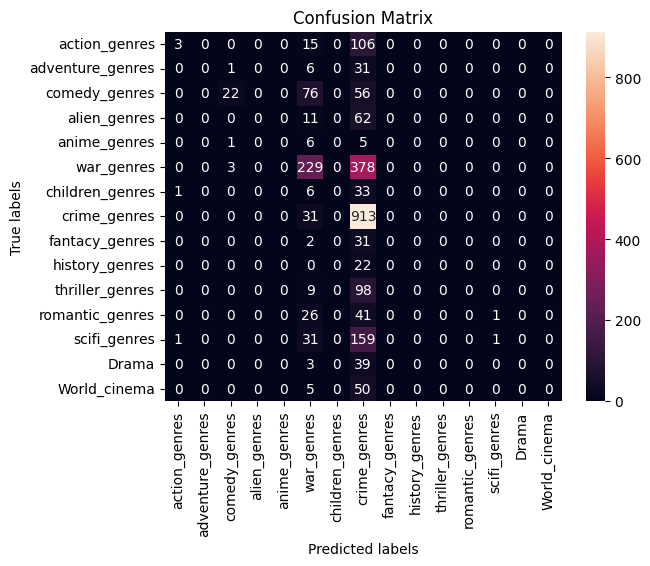

In [ ]:
print("Accuracy for Naive Bayes:",acc_nb)
print("F1 score",f1_score(ytest, predict_nb,average ='weighted'))
cf_matrix = ConfusionMatrix(ytest, predict_nb)

## Hypertuned Naive Bayes


In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold

cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                    n_repeats=3, 
                                    random_state=42)

In [ ]:
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import GridSearchCV

params_NB = {'alpha': np.logspace(-3,3,10)}

gs_NB = GridSearchCV(estimator=clf, 
                     param_grid=params_NB, 
                     cv=cv_method,
                     verbose=1, 
                     scoring='accuracy')

# Data_transformed = PowerTransformer().fit_transform(tf_x_test_gen.toarray())

gs_NB.fit(tf_x_train_gen, ytrain);

Fitting 15 folds for each of 10 candidates, totalling 150 fits


In [ ]:
import pickle
path_model =  "/content/drive/My Drive/Dataset_DSA/MovieSummaries/"
pickle.dump(gs_NB, open(path_model + 'Naive_Bayes_hypertuned.pkl','wb'))


In [ ]:
print(gs_NB.best_params_)
print(gs_NB.best_score_)


{'alpha': 0.1}
0.531271126548593


In [ ]:
results_NB = pd.DataFrame(gs_NB.cv_results_['params'])
results_NB['test_score'] = gs_NB.cv_results_['mean_test_score']

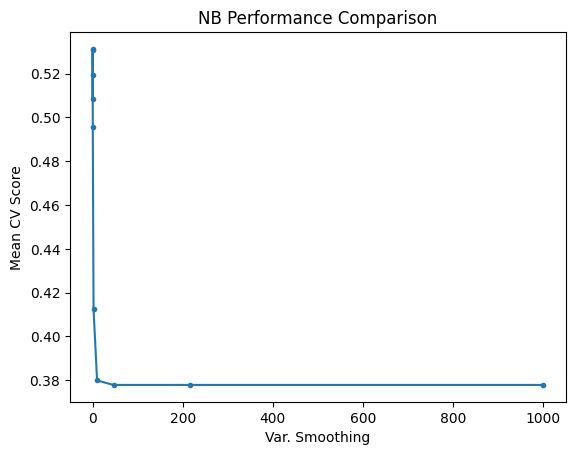

In [ ]:
plt.plot(results_NB['alpha'], results_NB['test_score'], marker = '.')    
plt.xlabel('Var. Smoothing')
plt.ylabel("Mean CV Score")
plt.title("NB Performance Comparison")
plt.show()

Accuracy for Hypertuned Naive Bayes:  0.5385839299920445
F1 score 0.48703468724497817


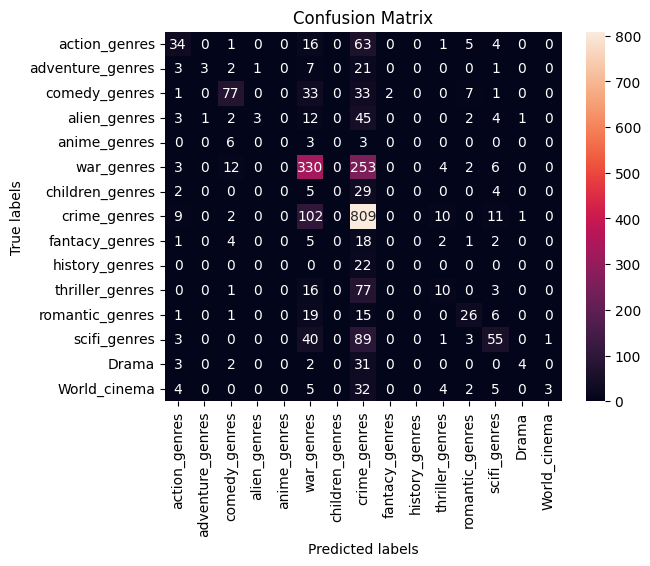

In [ ]:
predict_test = gs_NB.predict(tf_x_test_gen)
accuracy_test = accuracy_score(ytest,predict_test)
print('Accuracy for Hypertuned Naive Bayes: ', accuracy_test)
print("F1 score",f1_score(ytest, predict_test,average ='weighted'))
cf_matrix = ConfusionMatrix(ytest, predict_test)

In [ ]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

# Decision Tree

In [ ]:
clf_d=DecisionTreeClassifier()
clf_d.fit(tf_x_train_gen, ytrain)
predict=clf_d.predict(tf_x_test_gen)
acc_dt = accuracy_score(ytest, predict)


Accuracy for Decision Tree:  0.34009546539379476
F1 score:  0.33000228948953525


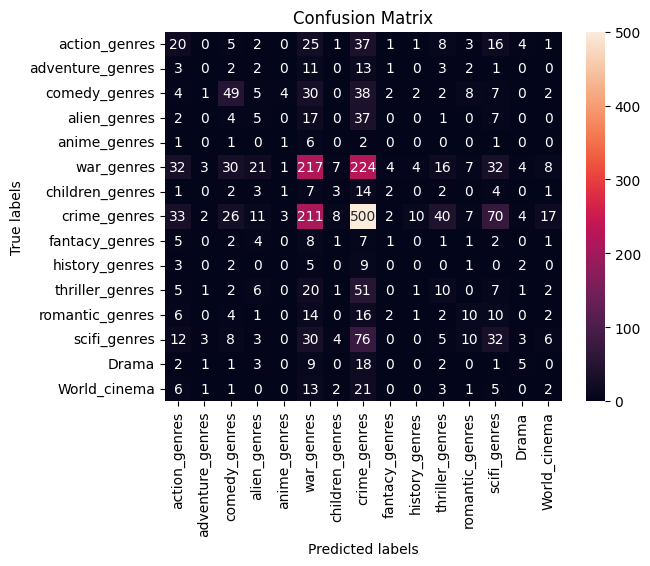

In [ ]:
print('Accuracy for Decision Tree: ', acc_dt)
print("F1 score: ",f1_score(ytest, predict,average ='weighted'))
cf_matrix = ConfusionMatrix(ytest, predict)

# Hyper Tuned Decision Tree

In [ ]:
from sklearn.model_selection import GridSearchCV
params = {
    'max_depth': [2, 3, 5, 10, 15],
    'min_samples_leaf': [5, 10, 20, 50],
    'criterion': ["gini", "entropy"]
}

In [ ]:
grid_search = GridSearchCV(estimator=clf_d, 
                           param_grid=params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")

In [ ]:
grid_search.fit(tf_x_train_gen, ytrain)
grid_search.best_estimator_


Fitting 4 folds for each of 40 candidates, totalling 160 fits


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5, 10, 15],
                         'min_samples_leaf': [5, 10, 20, 50]},
             scoring='accuracy', verbose=1)

In [ ]:
clf_d=DecisionTreeClassifier(criterion='gini',max_depth=30,min_samples_leaf=100)
clf_d.fit(tf_x_train_gen, ytrain)
predict=clf_d.predict(tf_x_test_gen)
acc_ht_dt = accuracy_score(ytest, predict)


Accuracy for Hypertuned Decision Tree:  0.41646778042959426
F1 score:  0.3431442321054731


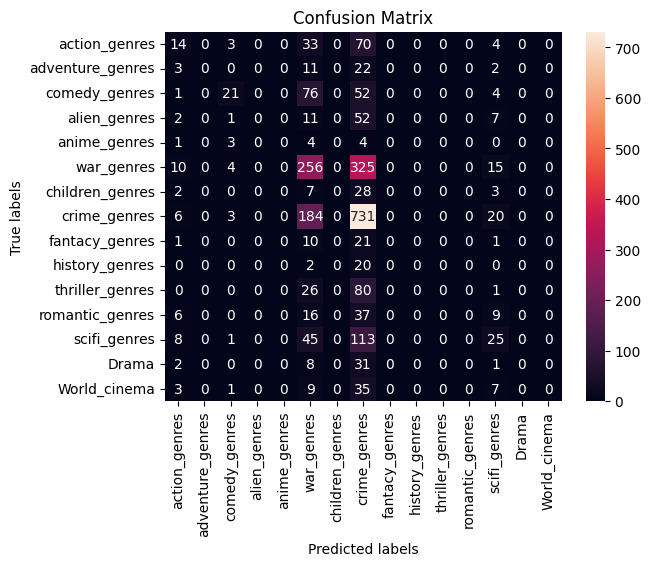

In [ ]:
print('Accuracy for Hypertuned Decision Tree: ', acc_ht_dt)
print("F1 score: ",f1_score(ytest, predict,average ='weighted'))
cf_matrix = ConfusionMatrix(ytest, predict)

# SVM

In [ ]:

from sklearn.svm import SVC
SVCClf = SVC(kernel = 'linear',gamma = 'scale', shrinking = False)
SVCClf.fit(tf_x_train_gen, ytrain)
predict_svm = SVCClf.predict(tf_x_test_gen)
acc_svm = accuracy_score(ytest, predict_svm)


Accuracy for SVM:  0.5568814638027049
F1 score:  0.5168393927119539


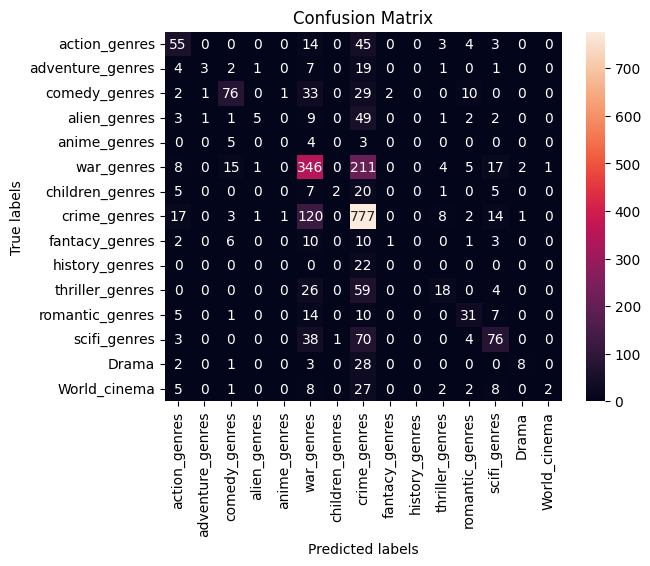

In [ ]:
print('Accuracy for SVM: ', acc_svm)
print("F1 score: ",f1_score(ytest, predict_svm,average ='weighted'))
cf_matrix = ConfusionMatrix(ytest, predict_svm)

## Hypertuned SVM

In [ ]:
"""
Caution will take a lot of time to run around 45-50 mins so please skip the Grid search 
"""

In [ ]:
from sklearn.model_selection import GridSearchCV
  
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma' : ['scale'], 
              'kernel': ['linear']} 
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 2)
  
# fitting the model for grid search
grid.fit(tf_x_train_gen, ytrain)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time= 2.4min
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time= 2.0min
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time= 2.0min
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time= 2.1min
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time= 2.1min
[CV] END ....................C=1, gamma=scale, kernel=linear; total time= 2.0min
[CV] END ....................C=1, gamma=scale, kernel=linear; total time= 2.0min
[CV] END ....................C=1, gamma=scale, kernel=linear; total time= 2.0min
[CV] END ....................C=1, gamma=scale, kernel=linear; total time= 2.0min
[CV] END ....................C=1, gamma=scale, kernel=linear; total time= 2.0min
[CV] END ...................C=10, gamma=scale, kernel=linear; total time= 2.1min
[CV] END ...................C=10, gamma=scale, ke

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': ['scale'],
                         'kernel': ['linear']},
             verbose=2)

In [ ]:
print("Best Parameters :",grid.best_params_)
print("best Estimators :",grid.best_estimator_)

Best Parameters : {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
best Estimators : SVC(C=1, kernel='linear')


In [ ]:
import pickle
path_model =  "/content/drive/My Drive/Dataset_DSA/MovieSummaries/"
pickle.dump(SVCClf, open(path_model + 'SVM.pkl','wb'))

In [ ]:
path_model =  "/content/drive/My Drive/Dataset_DSA/MovieSummaries/"
pickle.dump(grid, open(path_model + 'Hypertuned_SVM.pkl','wb'))

In [ ]:
"""
This will take 5-10mins these are the best features chosen after hyper parameter tuning 
"""
from sklearn.svm import SVC
SVCClf_ht = SVC(kernel = 'linear',gamma = 'scale', C = 1, shrinking = False)
SVCClf_ht.fit(tf_x_train_gen, ytrain)
predict_svm_ht= SVCClf_ht.predict(tf_x_test_gen)
acc_svm_ht = accuracy_score(ytest, predict_svm_ht)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Accuracy for Hypertuned SVM:  0.5568814638027049
F1 score:  0.5168393927119539


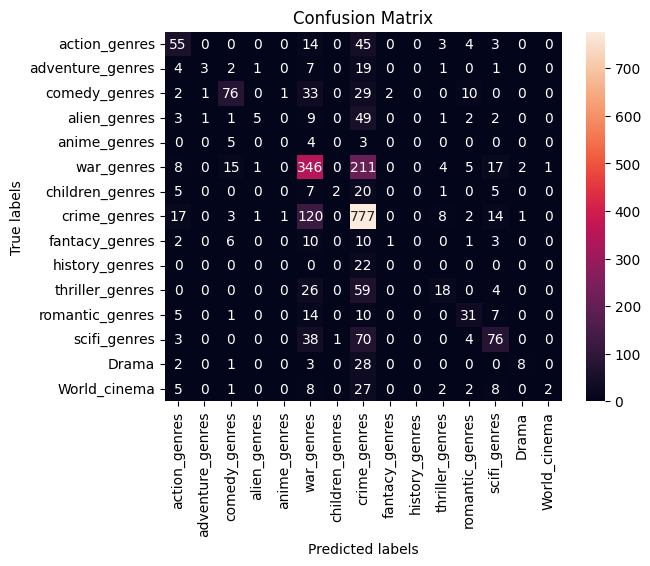

In [ ]:
print('Accuracy for Hypertuned SVM: ', acc_svm_ht)
print("F1 score: ",f1_score(ytest, predict_svm_ht,average ='weighted'))
cf_matrix = ConfusionMatrix(ytest, predict_svm_ht)

In [ ]:
# top_30 = counts.nlargest(30)
# top_30

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Evaluation Using Genre as the Target Variable


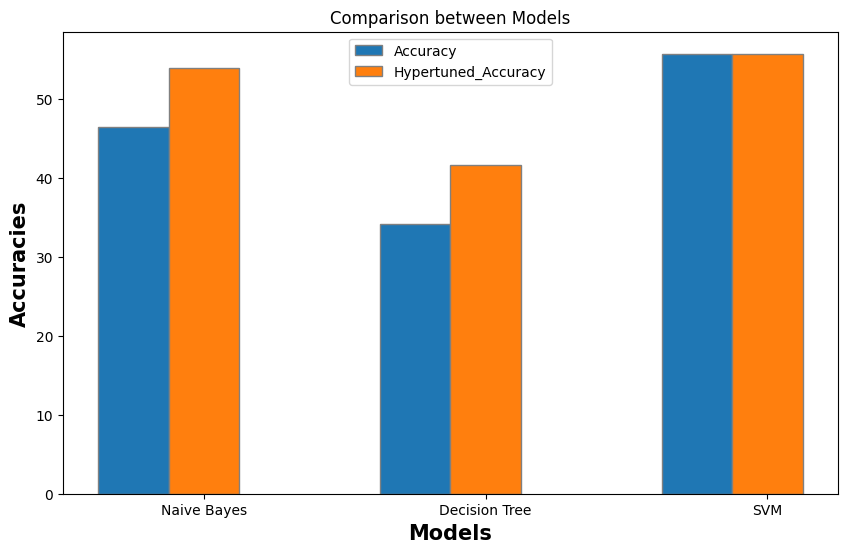

In [ ]:
barWidth = 0.25
fig = plt.subplots(figsize =(10, 6))

accuracy = [46.45,34.09,55.68]
ht_accuracy = [53.85,41.64,55.68]

br1 = np.arange(len(accuracy))
br2 = [x + barWidth for x in br1]

plt.bar(br1, accuracy, width = barWidth,
        edgecolor ='grey', label ='Accuracy')
plt.bar(br2, ht_accuracy, width = barWidth,
        edgecolor ='grey', label ='Hypertuned_Accuracy')

plt.xlabel('Models', fontweight ='bold', fontsize = 15)
plt.ylabel('Accuracies', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(accuracy))],
        ['Naive Bayes', 'Decision Tree', 'SVM'])
plt.title("Comparison between Models")
plt.legend()
plt.show()

## Now we are going to use different feature for the prediction **Country**

In [ ]:
data_country = new_df.copy()
data_country

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,MovieName,MovieReleaseDate,Revenue,Runtime,Language,Country,Genre,Summaries,text_clean,length
0,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],[Thriller],A series of murders of rich young women throug...,series murder rich young woman throughout ariz...,1
1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama],"Eva, an upper class housewife, becomes frustra...","eva, upper class housewife, becomes frustrated...",1
5,Aaah Belinda,1986,NaN,NaN,[Turkish Language],[Turkey],[Comedy],"Serap, a young actress with a strong, lively p...","serap, young actress strong, lively personalit...",1
10,Anbu Thozhi,2007-08-17,NaN,NaN,[Tamil Language],[India],[Romantic],The film opens with a simpleton from a small v...,film open simpleton small village tamil nadu w...,1
12,Bindiya Chamkegi,1984-01-20,NaN,NaN,[Hindi Language],[India],[Comedy],Shalini 'Shalu' lives a wealthy lifestyle with...,shalini 'shalu' life wealthy lifestyle busines...,1
...,...,...,...,...,...,...,...,...,...,...
42190,The Flying Serpent,1946,NaN,59.0,[],[United States of America],[Thriller],Insane archaeologist Professor Andrew Forbes ...,insane archaeologist professor andrew forbes u...,1
42192,State and Main,2000-08-26,6944471.0,106.0,"[Italian Language, English Language]","[France, United States of America]",[Comedy],Havoc is wrought on the inhabitants of a small...,havoc wrought inhabitant small new england tow...,1
42198,Mermaids: The Body Found,2011-03-19,NaN,120.0,[English Language],[United States of America],[Drama],Two former National Oceanic Atmospheric Admini...,two former national oceanic atmospheric admini...,1
42199,Knuckle,2011-01-21,NaN,96.0,[English Language],"[Ireland, United Kingdom]",[Drama],{{No plot}} This film follows 12 years in the ...,{{no plot}} film follows 12 year life 3 irish ...,1


In [ ]:
## Chossing only 7 countries as the countries
k=0

for i in data_country["Country"]:
  for j in i:
    if j =="United States of America":
      data_country.at[k,"Country"]=j
      break
    elif j =="United Kingdom":
      data_country.at[k,"Country"]=j
      break
    elif j =="South Africa":
      data_country.at[k,"Country"]=j
      break
    elif j =="France":
      data_country.at[k,"Country"]=j
      break
    elif j =="Mexico":
      data_country.at[k,"Country"]=j
      break
    elif j == "India":
      data_country.at[k,"Country"]=j
      break
    elif j == "Turkey":
      data_country.at[k,"Country"]=j
      break
    else:
      continue
  k=k+1
      


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
data_country

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,MovieName,MovieReleaseDate,Revenue,Runtime,Language,Country,Genre,Summaries,text_clean,length
0,White Of The Eye,1987,NaN,110.0,[English Language],United Kingdom,[Thriller],A series of murders of rich young women throug...,series murder rich young woman throughout ariz...,1.0
1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama],"Eva, an upper class housewife, becomes frustra...","eva, upper class housewife, becomes frustrated...",1.0
5,Aaah Belinda,1986,NaN,NaN,[Turkish Language],India,[Comedy],"Serap, a young actress with a strong, lively p...","serap, young actress strong, lively personalit...",1.0
10,Anbu Thozhi,2007-08-17,NaN,NaN,[Tamil Language],United States of America,[Romantic],The film opens with a simpleton from a small v...,film open simpleton small village tamil nadu w...,1.0
12,Bindiya Chamkegi,1984-01-20,NaN,NaN,[Hindi Language],[India],[Comedy],Shalini 'Shalu' lives a wealthy lifestyle with...,shalini 'shalu' life wealthy lifestyle busines...,1.0
...,...,...,...,...,...,...,...,...,...,...
12557,NaN,NaN,NaN,NaN,NaN,United States of America,NaN,NaN,NaN,NaN
12558,NaN,NaN,NaN,NaN,NaN,United States of America,NaN,NaN,NaN,NaN
12559,NaN,NaN,NaN,NaN,NaN,India,NaN,NaN,NaN,NaN
12563,NaN,NaN,NaN,NaN,NaN,United States of America,NaN,NaN,NaN,NaN


In [ ]:
# Keeping only rows with those 7 countries
k=0
for i in data_country["Country"]:
  if i == 'United States of America':
    k=k+1
  elif i == 'United Kingdom':
    k=k+1
  elif i == 'South Africa':
    k=k+1
  elif i == 'France':
    k=k+1
  elif i == 'Mexico':
    k=k+1
  elif i == 'India':
    k+=1
  elif i == 'Turkey':
    k+=1
  else :
    data_country.drop(k,axis=0,inplace=True)
    data_country.reset_index(drop=True,inplace=True)  


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
data_country = data_country.astype(str)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
country_list = ['USA','UK','South Africa','France', 'Mexico','India','Turkey']
def ConfusionMatrixcountry(ytest,y_pred):
  cf_matrix = confusion_matrix(ytest, y_pred)
  ax= plt.subplot()
  sns.heatmap(cf_matrix, annot=True, fmt='g', ax=ax);  
  ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
  ax.set_title('Confusion Matrix')
  ax.xaxis.set_ticklabels(country_list); ax.yaxis.set_ticklabels(country_list)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
  plt.yticks(rotation = 0)
  plt.show()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from sklearn import preprocessing
import pandas as pd
le = preprocessing.LabelEncoder()

data_country['Country'] = le.fit_transform(data_country['Country'])

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
data_country

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,MovieName,MovieReleaseDate,Revenue,Runtime,Language,Country,Genre,Summaries,text_clean,length
0,White Of The Eye,1987,nan,110.0,['English Language'],415,['Thriller'],A series of murders of rich young women throug...,series murder rich young woman throughout ariz...,1
1,A Woman in Flames,1983,nan,106.0,['German Language'],214,['Drama'],"Eva, an upper class housewife, becomes frustra...","eva, upper class housewife, becomes frustrated...",1
5,Aaah Belinda,1986,nan,nan,['Turkish Language'],403,['Comedy'],"Serap, a young actress with a strong, lively p...","serap, young actress strong, lively personalit...",1
10,Anbu Thozhi,2007-08-17,nan,nan,['Tamil Language'],233,['Romantic'],The film opens with a simpleton from a small v...,film open simpleton small village tamil nadu w...,1
12,Bindiya Chamkegi,1984-01-20,nan,nan,['Hindi Language'],233,['Comedy'],Shalini 'Shalu' lives a wealthy lifestyle with...,shalini 'shalu' life wealthy lifestyle busines...,1
...,...,...,...,...,...,...,...,...,...,...
42190,The Flying Serpent,1946,nan,59.0,[],538,['Thriller'],Insane archaeologist Professor Andrew Forbes ...,insane archaeologist professor andrew forbes u...,1
42192,State and Main,2000-08-26,6944471.0,106.0,"['Italian Language', 'English Language']",198,['Comedy'],Havoc is wrought on the inhabitants of a small...,havoc wrought inhabitant small new england tow...,1
42198,Mermaids: The Body Found,2011-03-19,nan,120.0,['English Language'],538,['Drama'],Two former National Oceanic Atmospheric Admini...,two former national oceanic atmospheric admini...,1
42199,Knuckle,2011-01-21,nan,96.0,['English Language'],243,['Drama'],{{No plot}} This film follows 12 years in the ...,{{no plot}} film follows 12 year life 3 irish ...,1


In [ ]:
x_train_con, x_test_con, y_train_con, y_test_con = train_test_split(data_country['text_clean'],
                                              data_country['Country'], test_size=0.2)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#for TF
tfidf_vectorizer_con = TfidfVectorizer(max_df=0.8, max_features=10000)
tf_x_train_con = tfidf_vectorizer_con.fit_transform(x_train_con)
tf_x_test_con = tfidf_vectorizer_con.transform(x_test_con)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#@title Naive Bayes
clf_mn_con=MultinomialNB()
clf_mn_con.fit(tf_x_train_con, y_train_con)
predict_mn=clf_mn_con.predict(tf_x_test_con)
acc_mn = accuracy_score(y_test_con, predict_mn)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.6346604215456675

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Accuracy for Naive Bayes:  0.6346604215456675
F1 score:  0.4928165450970656


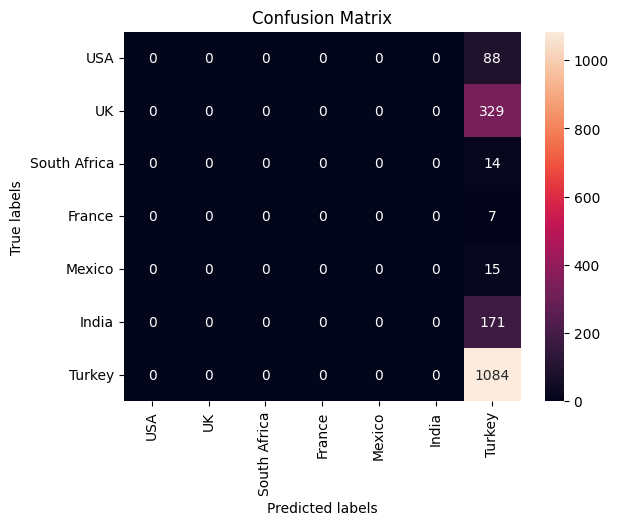

In [ ]:
print('Accuracy for Naive Bayes: ', acc_mn)
print("F1 score: ",f1_score(y_test_con, predict_mn,average ='weighted'))
cf_matrix = ConfusionMatrixcountry(y_test_con, predict_mn)

In [ ]:
#@title Decision Tree
clf_d_con=DecisionTreeClassifier()
clf_d_con.fit(tf_x_train_con, y_train_con)
predict_d=clf_d_con.predict(tf_x_test_con)
acc_d = accuracy_score(y_test_con, predict_d)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.5872365339578455

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Accuracy for Decision Tree :  0.5872365339578455
F1 score:  0.5064833930492503


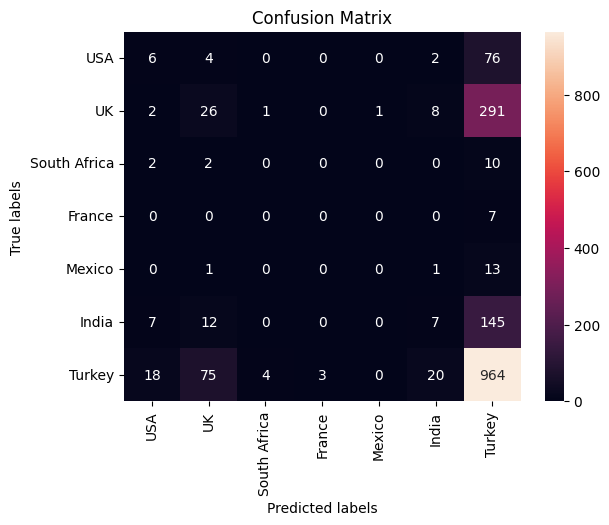

In [ ]:
print('Accuracy for Decision Tree : ', acc_d)
print("F1 score: ",f1_score(y_test_con, predict_d,average ='weighted'))
cf_matrix = ConfusionMatrixcountry(y_test_con, predict_d)

In [ ]:
#@title SVM
clf_svc_con=SVC().fit(tf_x_train_con, y_train_con)
predict_svc=clf_svc_con.predict(tf_x_test_con)
acc_svc = accuracy_score(y_test_con, predict_svc)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.6346604215456675


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Accuracy for SVM:  0.6346604215456675
F1 score:  0.4928165450970656


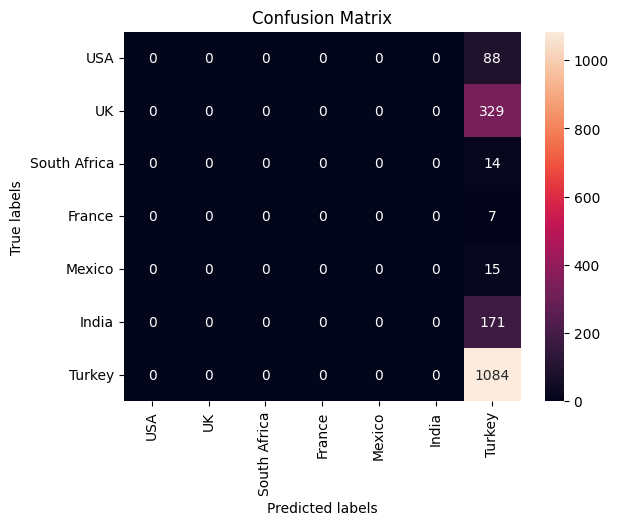

In [ ]:
print('Accuracy for SVM: ', acc_svc)
print("F1 score: ",f1_score(y_test_con, predict_svc,average ='weighted'))
cf_matrix = ConfusionMatrixcountry(y_test_con, predict_svc)

In [ ]:
accuracies =  [63.466,58.723,63.466]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


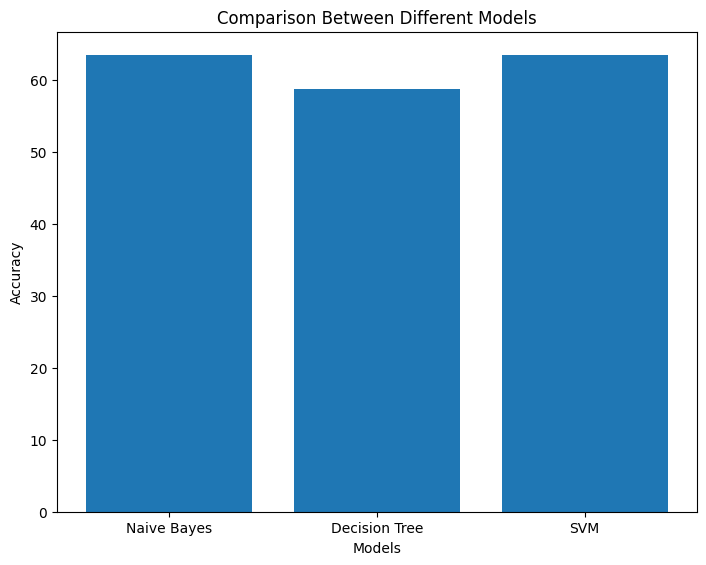

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
models = ['Naive Bayes', 'Decision Tree', 'SVM']
accuracies = [63.466, 58.723, 63.466]
ax.bar(models,accuracies)
plt.title("Comparison Between Different Models")
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.show()

#**Part II - Clustering**

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split



import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Embedding
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot


from gensim.models import LdaModel

!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim
import pickle 

from pprint import pprint
from gensim.corpora import Dictionary
import pyLDAvis.gensim

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
df = df_cluster

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df = df[:1000]
df

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,WikipediaMovieID,FreebaseMovieID,MovieName,MovieReleaseDate,Revenue,Runtime,Language,Country,Genre,Summaries,text_clean
0,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",A series of murders of rich young women throug...,series murder rich young woman throughout ariz...
1,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama],"Eva, an upper class housewife, becomes frustra...","eva, upper class housewife, becomes frustrated..."
2,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,NaN,86.0,[English Language],[South Africa],"[Family Film, Fantasy, Adventure, World cinema]","Every hundred years, the evil Morgana returns...","every hundred years, evil morgana return claim..."
3,6631279,/m/0gffwj,Little city,1997-04-04,NaN,93.0,[English Language],[United States of America],"[Romantic comedy, Ensemble Film, Comedy-drama,...","Adam, a San Francisco-based artist who works a...","adam, san francisco-based artist work cab driv..."
4,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,[English Language],[United Kingdom],"[Costume drama, War film, Epic, Period piece, ...",{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...,{{plot|dateact 1act 2act 3act 4act 5 finally n...
...,...,...,...,...,...,...,...,...,...,...,...
995,1456329,/m/052_dz,An American Tail: Fievel Goes West,1991-11-22,65435625.0,76.0,[English Language],[United States of America],"[Adventure, Children's/Family, Animation, Chil...","While living in The Bronx, the Mousekewitz fa...","living bronx, mousekewitz family find conditio..."
996,30552151,/m/0g9xp_7,Line Engaged,1935-11,NaN,68.0,[English Language],[United Kingdom],[Thriller],"Eva Rutland , the wife of caddish Gordon , is ...","eva rutland , wife caddish gordon , love david..."
997,8293411,/m/026z9wt,Wedding Wars,2006,NaN,87.0,[English Language],"[United States of America, Canada]","[LGBT, Romantic comedy, Romance Film, Comedy]","Shel , a gay party planner, agrees to organize...","shel , gay party planner, agrees organize nupt..."
998,27403920,/m/0c0197f,Oil for the Lamps of China,1935,NaN,97.0,[English Language],[United States of America],"[Melodrama, Drama]","Ambitious, idealistic Stephen Chase goes to w...","ambitious, idealistic stephen chase go work at..."


In [ ]:
df["text_clean_genre"] = df["Genre"].apply(lambda x: " ".join(x)) + df["Genre"].apply(lambda x: " ".join(x)) + df["text_clean"]
df

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-186-4c53e2666a15>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["text_clean_genre"] = df["Genre"].apply(lambda x: " ".join(x)) + df["Genre"].apply(lambda x: " ".join(x)) + df["text_clean"]


,WikipediaMovieID,FreebaseMovieID,MovieName,MovieReleaseDate,Revenue,Runtime,Language,Country,Genre,Summaries,text_clean,text_clean_genre
0,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",A series of murders of rich young women throug...,series murder rich young woman throughout ariz...,Thriller Erotic thriller Psychological thrille...
1,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama],"Eva, an upper class housewife, becomes frustra...","eva, upper class housewife, becomes frustrated...","DramaDramaeva, upper class housewife, becomes ..."
2,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,NaN,86.0,[English Language],[South Africa],"[Family Film, Fantasy, Adventure, World cinema]","Every hundred years, the evil Morgana returns...","every hundred years, evil morgana return claim...",Family Film Fantasy Adventure World cinemaFami...
3,6631279,/m/0gffwj,Little city,1997-04-04,NaN,93.0,[English Language],[United States of America],"[Romantic comedy, Ensemble Film, Comedy-drama,...","Adam, a San Francisco-based artist who works a...","adam, san francisco-based artist work cab driv...",Romantic comedy Ensemble Film Comedy-drama Dra...
4,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,[English Language],[United Kingdom],"[Costume drama, War film, Epic, Period piece, ...",{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...,{{plot|dateact 1act 2act 3act 4act 5 finally n...,Costume drama War film Epic Period piece Drama...
...,...,...,...,...,...,...,...,...,...,...,...,...
995,1456329,/m/052_dz,An American Tail: Fievel Goes West,1991-11-22,65435625.0,76.0,[English Language],[United States of America],"[Adventure, Children's/Family, Animation, Chil...","While living in The Bronx, the Mousekewitz fa...","living bronx, mousekewitz family find conditio...",Adventure Children's/Family Animation Children...
996,30552151,/m/0g9xp_7,Line Engaged,1935-11,NaN,68.0,[English Language],[United Kingdom],[Thriller],"Eva Rutland , the wife of caddish Gordon , is ...","eva rutland , wife caddish gordon , love david...","ThrillerThrillereva rutland , wife caddish gor..."
997,8293411,/m/026z9wt,Wedding Wars,2006,NaN,87.0,[English Language],"[United States of America, Canada]","[LGBT, Romantic comedy, Romance Film, Comedy]","Shel , a gay party planner, agrees to organize...","shel , gay party planner, agrees organize nupt...",LGBT Romantic comedy Romance Film ComedyLGBT R...
998,27403920,/m/0c0197f,Oil for the Lamps of China,1935,NaN,97.0,[English Language],[United States of America],"[Melodrama, Drama]","Ambitious, idealistic Stephen Chase goes to w...","ambitious, idealistic stephen chase go work at...","Melodrama DramaMelodrama Dramaambitious, ideal..."


In [ ]:

def getWordList(df):  
  words_list = []
  #for plot in df["text_clean"]:
  for plot in df["text_clean_genre"]:
    words_list.append(plot.split())
  return words_list


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#@title Dictionary Creation
words_list = getWordList(df)
dictionary_text_clean = Dictionary(words_list)
#Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary_text_clean.filter_extremes(no_below=20, no_above=0.5)
corpus_bow = [dictionary_text_clean.doc2bow(doc) for doc in words_list]
print('Number of unique tokens: %d' % len(dictionary_text_clean), "  for dictionary_text_clean")
print('Number of documents: %d' % len(corpus_bow), "  for corpus_bow")


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Number of unique tokens: 1081   for dictionary_text_clean
Number of documents: 1000   for corpus_bow


In [ ]:
#@title LDA model
id2word_lemm = dictionary_text_clean.id2token
temp = dictionary_text_clean[0]  # This is only to "load" the dictionary.
c = dictionary_text_clean.id2token

# While training we experimented with a lot of num_topics, used 10 here for faster execution
num_topics = 10
chunksize = 2000
passes = 20
iterations = 400
eval_every = None 

LDAmodel = LdaModel(
    corpus=corpus_bow,
    id2word=id2word_lemm,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

top_topics = LDAmodel.top_topics(corpus_bow) #, num_words=20)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

lda_topics = LDAmodel.get_topics()
top_topic_list_lda = [item[1] for item in top_topics[0][0]]
print("TOP Topic of entire model",top_topic_list_lda)

top_terms_per_cluster_lemm = []
for i in range(num_topics):
    top_terms = LDAmodel.show_topic(i, topn=20)
    top_terms_per_cluster_lemm.append([term[0] for term in top_terms])

# print the top terms per cluster
for i, top_terms in enumerate(top_terms_per_cluster_lemm):
    print(f"Cluster {i}: {' '.join(top_terms)}")
    #print(top_terms_per_cluster[i])



pyLDAvis.enable_notebook()
visualisation = pyLDAvis.gensim.prepare(LDAmodel, corpus_bow, dictionary=dictionary_text_clean)
visualisation.plot_opts
topics = visualisation.topic_coordinates.index.values
clusters = visualisation.topic_coordinates.groupby('cluster').groups.values()

#Define which movie Belongs to which Cluster
doc_topic_probs = [LDAmodel.get_document_topics(doc) for doc in corpus_bow]
doc_topic_ids = [max(tp, key=lambda x: x[1])[0] for tp in doc_topic_probs]
df['cluster'] = doc_topic_ids

visualisation

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Average topic coherence: -1.4577.
TOP Topic of entire model ['find', 'get', 'tell', 'go', 'him.', 'back', 'house', 'take', ',', 'her.', 'try', 'begin', 'give', 'asks', 'see', 'next', 'one', 'him,', 'two', 'return']
Cluster 0: miss , school one mr. go man film back young find return girl new take boy . bill two teacher
Cluster 1: find get tell go him. back house take , her. try begin give asks see next one him, two return
Cluster 2: one see find tell take Film get back go . try come Fantasy it. story like her, end help land
Cluster 3: Drama , Romance love World cinema Film Romantic film drama Comedy get . life family comedy fall meet make come
Cluster 4: dr. one , get team find go also kid joe take play back try begin time make return tell however,
Cluster 5: Film Comedy film Family Romance Drama comedy Short child , take girl man new make Fantasy . movie of friend
Cluster 6: , life family young find Drama husband also film new . mother time Film one get mary woman wife go
Cluster 7: fa

/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
<ipython-input-192-71c9607f31db>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = doc_topic_ids


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.010802 -0.077449       1        1  17.076313
9     -0.102926 -0.048626       2        1  14.452338
4     -0.018016 -0.024762       3        1  14.316010
3      0.108166  0.083975       4        1  13.212189
6      0.040239  0.044415       5        1  10.599569
5      0.117612 -0.070282       6        1   7.472093
8     -0.077403  0.042036       7        1   6.410738
0      0.031229  0.009527       8        1   6.148417
2     -0.023843 -0.081426       9        1   5.406763
7     -0.064255  0.122592      10        1   4.905569, topic_info=        Term        Freq       Total Category  logprob  loglift
200     Film  655.000000  655.000000  Default  30.0000  30.0000
228   Comedy  398.000000  398.000000  Default  29.0000  29.0000
515    Crime  233.000000  233.000000  Default  28.0000  28.0000
377   father  304.000000  304.000000  Default  27.0000  27.0000
231  Romance  285.000000  285.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
48      kill   21.552479  270.497003  Topic10  -5.1730   0.4850
120  becomes   20.725077  251.678144  Topic10  -5.2121   0.5180
134   friend   20.743318  324.017706  Topic10  -5.2112   0.2662
500   mother   19.787772  217.984758  Topic10  -5.2584   0.6154
104      try   19.801226  366.755591  Topic10  -5.2577   0.0958

[607 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
343       1  0.218342     "the
343       2  0.054586     "the
343       3  0.150110     "the
343       5  0.027293     "the
343       6  0.177403     "the
...     ...       ...      ...
1048      3  0.019064  younger
1048      4  0.324090  younger
1048      5  0.171577  younger
1048      7  0.038128  younger
1048     10  0.285962  younger

[2767 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 10, 5, 4, 7, 6, 9, 1, 3, 8])

In [ ]:

#@title Common Calculations for GM/KMeans
from sklearn.manifold import TSNE
X = df["text_clean_genre"]
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tf_x = tfidf_vectorizer.fit_transform(X)

tsne_model = TSNE(n_components=2)
tsne_fit=tsne_model.fit_transform(tf_x.toarray())

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


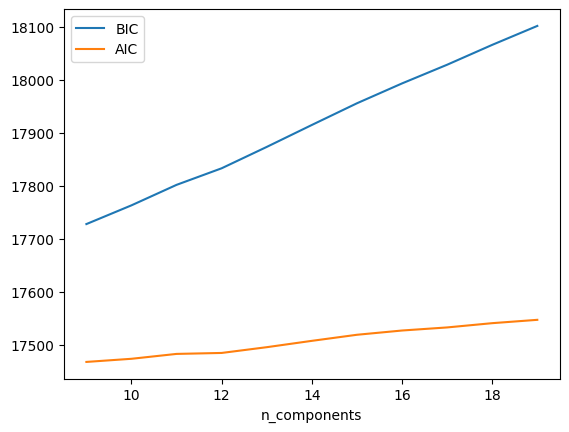

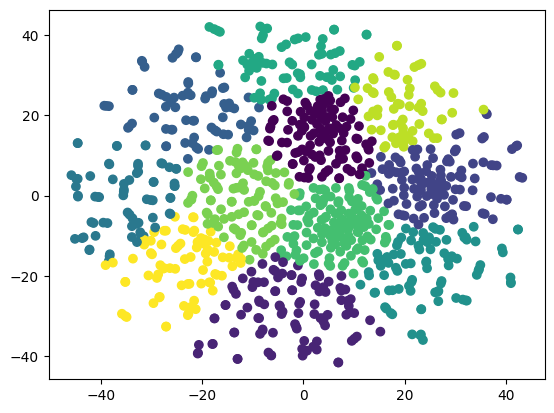

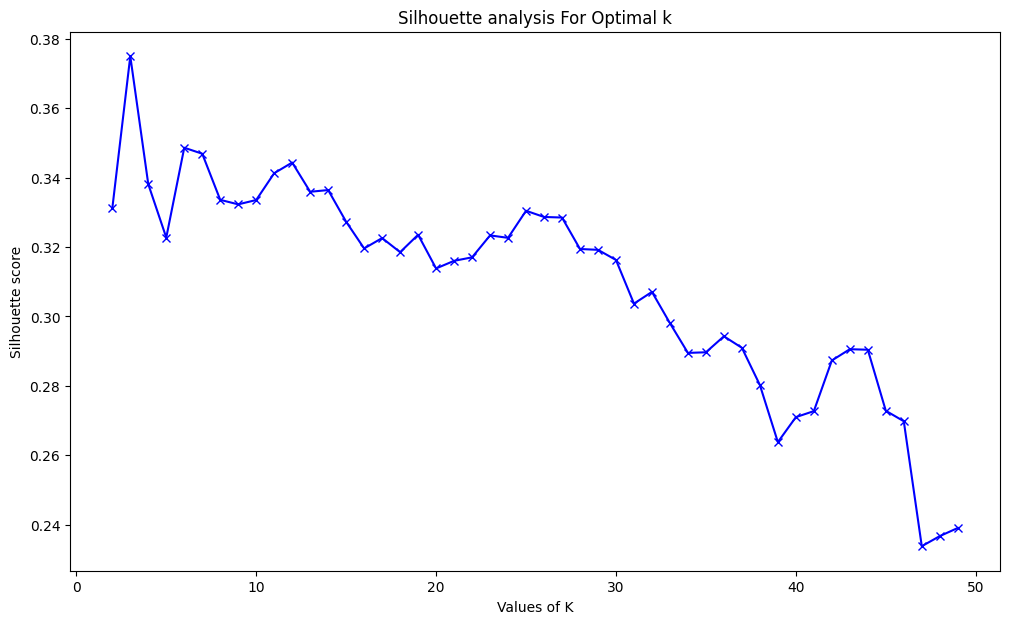

In [ ]:
#@title EM/GMM Model
"""
EM/GMM
"""

from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture

silhouette_avg = []

# While training we experimented with wide range for n_components, used 9-20 here for faster execution
n_components = np.arange(9, 20)
X = tf_x.toarray()

models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(tsne_fit) for n in n_components]
# kappa_scores = [get_kappa_score(tsne_fit, model) for model in models]
plt.plot(n_components, [m.bic(tsne_fit) for m in models], label='BIC')
plt.plot(n_components, [m.aic(tsne_fit) for m in models], label='AIC')
min_aic_val = 20000
min_aic_index = 0
for i in range(len(models)):
  m = models[i]
  if m.bic(tsne_fit) < min_aic_val:
    min_aic_index = i

optimum_component = min_aic_index+1
plt.legend(loc='best')
plt.xlabel('n_components');
plt.show()
plt.close()
gmm = GaussianMixture(n_components=optimum_component)
gmm.fit(tsne_fit)
labels = gmm.predict(tsne_fit)
plt.scatter(tsne_fit[:, 0], tsne_fit[:, 1], c=labels, cmap='viridis');
plt.show()
plt.close()
K=range(2,50)
silhouette_avg = []
for k in K:
  gmm_m = GaussianMixture(n_components = k, covariance_type='full', random_state=0).fit(tsne_fit)
  cluster_labels = gmm_m.predict(tsne_fit)
  silhouette_avg.append(silhouette_score(tsne_fit, cluster_labels))
plt.figure(figsize=(12,7))
plt.plot(K,silhouette_avg,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


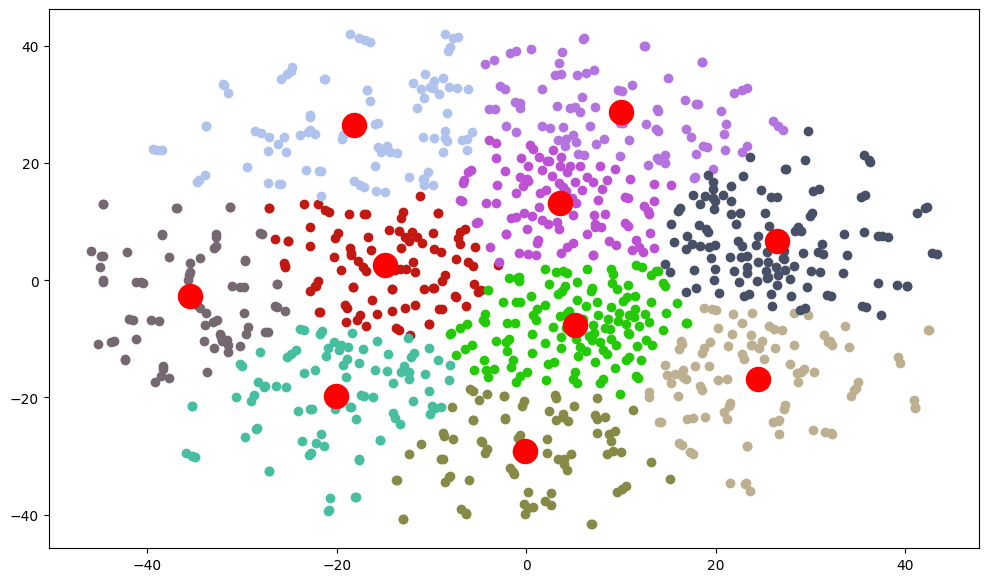

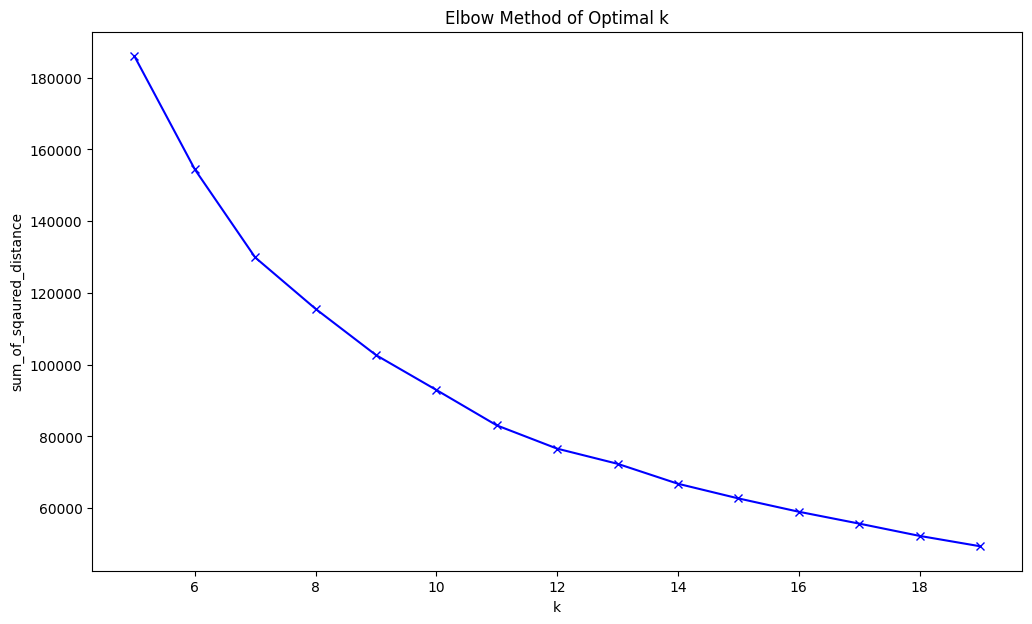

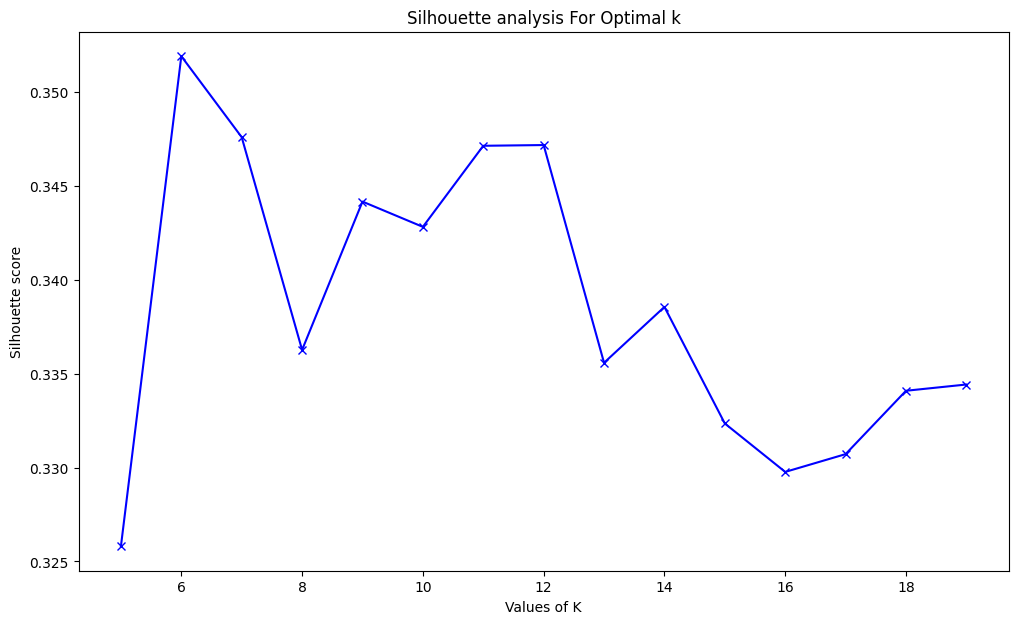

In [ ]:
#@title KMeans Model
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# While training we experimented with wide range for number of clusters n, used 10 here for faster execution
n=10

import random
color_maps = {}
for j in range(n):
    color = '#{:06x}'.format(random.randint(0, 0xFFFFFF))
    color_maps[j] = color


#labels_color_map = {0: '#20b2aa', 1: '#ff7373', 2: '#ffe4e1', 3: '#005073', 4: '#4d0404'}
tsne_model_km = TSNE(n_components=2)


X = tf_x.toarray()


kmeans = KMeans(n_clusters=n, init='k-means++', max_iter=300, n_init=10, random_state=0)
label = kmeans.fit_predict(tsne_fit)
plt.figure(figsize=(12,7))
for i in range(n):
  filtered_label=tsne_fit[label==i]
  color = color_maps[i]
  plt.scatter(filtered_label[:,0] , filtered_label[:,1] , c =color)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()
wcss=[]

# While training we experimented with wide range for K, used 5-20 here for faster execution
K=range(5,20)
silhouette_avg = []
for k in K:
  kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
  kmeans.fit(tsne_fit)
  wcss.append(kmeans.inertia_)
  cluster_labels = kmeans.labels_
  silhouette_avg.append(silhouette_score(tsne_fit, cluster_labels))
plt.figure(figsize=(12,7))
plt.plot(K, wcss,'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_sqaured_distance')
plt.title("Elbow Method of Optimal k")
plt.show()
plt.figure(figsize=(12,7))
plt.plot(K,silhouette_avg,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()  






/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


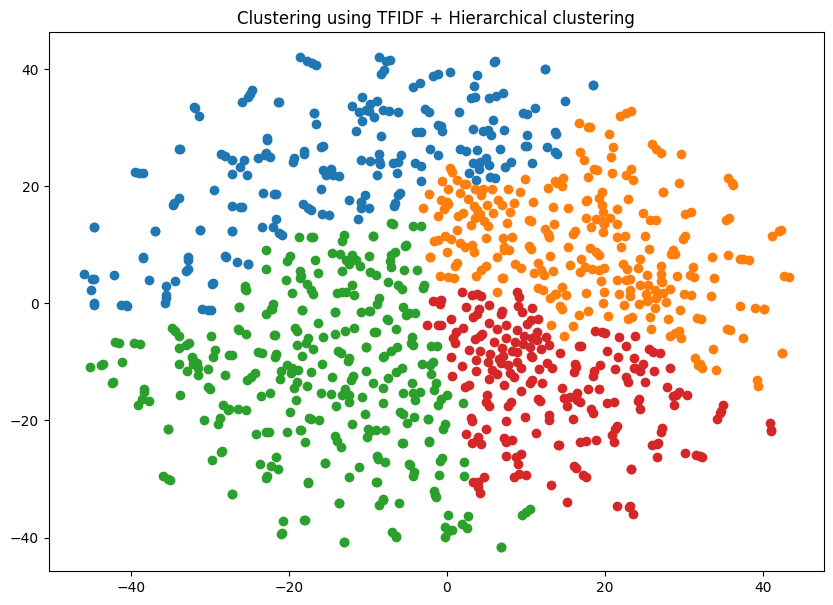

In [ ]:
#@title AgglomerativeClustering Model
labels_color_map = {
    0: '#20b2aa', 1: '#ff7373', 2: '#ffe4e1', 3: '#005073', 4: '#4d0404'}
plt.figure(figsize=(10, 7))
plt.title("Clustering using TFIDF + Hierarchical clustering")

# create clusters
hc = AgglomerativeClustering(n_clusters=4, affinity = 'euclidean', linkage = 'ward')
# save clusters for chart
y_hc = hc.fit_predict(tsne_fit)
n = 5
for i in range(n):
  filtered_label=tsne_fit[y_hc==i]
  # color = labels_color_map[i]
  plt.scatter(filtered_label[:,0] , filtered_label[:,1])

# plt.scatter(y_hc.cluster_centers_[:, 0], y_hc.cluster_centers_[:, 1], s=300, c='red')
plt.show()